# Victoria House Prices with Data Integration.
#### Name: Chandra Teja Doredla<br>
#### email: dchandrateja@gmail.com<br>


Environment: Python 3.6.0 and Anaconda 4.3.0 (64-bit)

Libraries used:
* pandas 0.19.2 (for data frame, included in Anaconda Python 3.6) 
* matplotlib 3.0.3 (for plotting visualization graphs, included in Anaconda Python 3.6)
* seaborn 0.9.0 (for plotting visualization graphs, included in Anaconda Python 3.6)
* numpy 1.16.2 (for performing computations, included in Anaconda Python 3.6)
* sklearn 0.20.3 (for building machine learning models, included in Anaconda Python 3.6)
* Dask 1.1.4 ( for implementing the parallel programming in python 3) can be installed using conda install dask distributed -c conda-forge
* geopandas 1.16.2(for manuplating the shape files)

#### Table of contents
***
[1. Introduction](#intro)<br>
[2. Import libraries](#lib)<br>
[3.Loading the data](#load)<br>
[4.Average crime columns(crime_A_average,crime_B_average,crime_C_average)](#crime)<br>
[5.Reading the gtfs data](#gtfs)<br>
[6.train_station_id & distance_to_train_station](#station)<br>
[7.travel_min_to_CBD](#time)<br>
[8.over priced](#price)<br>
[10.conclusion](#conclusion)<br>
[11.References](#references)<br>

<br>


### 1. Introduction<br>
<a id=intro></a>
This asssignment comprises of integrating different data and reshaping the data to better build a model.
We are provided with gtfs_data,stutdent_id.csv,victoria_shape_file.<br>
1. `student_id.csv` is the data of the properties in the melbourne.<br>
2. `victoria shape_file` has the geometrical data which helps to identify the suburb of a property.<br>
3. `gtfs_data` the gtfs data gives the data of the public transport which helps to determine the services to the CBD.
4. `crimebylocationdatatable-yearending31march2016.xlsx` which helps get the crime data based on the council.

### 2. Import libraries.
<a id=lib></a>

In [ ]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import re
import numpy as np
import datetime as dt
import time
from math import sin,radians,sqrt,cos,atan2
from datetime import timedelta
from datetime import datetime, date
import numpy as np
import dask.dataframe as dd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

### 3.Loading the given data.
<a id=load></a>

In [2]:
df=pd.read_csv('prices.csv')
df.head()

,ID,Address,Rooms,Type,Price,Date,Bathroom,Car,Landsize,Age,Lattitude,Longtitude
0,ID256597507,18 Grimwade Ct,3,h,528000.0,27/05/2017,2.0,1.0,525.0,6.0,-37.65070,145.04681
1,ID464726065,168 Scotchmer St,3,h,1581000.0,28/05/2016,1.0,0.0,193.0,109.0,-37.78360,144.98500
2,ID857676762,87 Palmerston St,3,h,1263000.0,9/09/2017,1.0,1.0,110.0,139.0,-37.79667,144.97204
3,ID608833881,24 Mater St,2,h,1025000.0,3/06/2017,2.0,1.0,108.0,14.0,-37.79531,144.98630
4,ID774776006,27 Vantage Bvd,4,h,800000.0,19/08/2017,2.0,2.0,511.0,6.0,-37.59372,144.89449


In [3]:
#checking if there are any duplicate rows in the data
df.describe(include='O')

,ID,Address,Type,Date
count,720,720,720,720
unique,675,675,3,56
top,ID990787112,32 Myrtle St,h,12/08/2017
freq,2,2,502,29


In [4]:
#we can see that there are duplicate rows in the given data hence dropping the rows.
df=df.drop_duplicates()

Now creating the geom data(creating the point object for each lat and long of the property) from the given latitude and longitude to check a location is present in the suburb area i.e the polygon data type of each suburb.

In [5]:
geom=df.apply(lambda x: Point(x['Longtitude'],x['Lattitude']),axis=1)
new_df=gpd.GeoDataFrame(df,geometry=geom)#adding the point objects as a column to the dataframe.
new_df.crs={'init' :'epsg:4326'}#setting up the coordinate reference ssystem.
new_df.head()

,ID,Address,Rooms,Type,Price,Date,Bathroom,Car,Landsize,Age,Lattitude,Longtitude,geometry
0,ID256597507,18 Grimwade Ct,3,h,528000.0,27/05/2017,2.0,1.0,525.0,6.0,-37.65070,145.04681,POINT (145.0468100000001 -37.6507)
1,ID464726065,168 Scotchmer St,3,h,1581000.0,28/05/2016,1.0,0.0,193.0,109.0,-37.78360,144.98500,POINT (144.985 -37.7836)
2,ID857676762,87 Palmerston St,3,h,1263000.0,9/09/2017,1.0,1.0,110.0,139.0,-37.79667,144.97204,POINT (144.97204 -37.79667)
3,ID608833881,24 Mater St,2,h,1025000.0,3/06/2017,2.0,1.0,108.0,14.0,-37.79531,144.98630,POINT (144.9863 -37.79531)
4,ID774776006,27 Vantage Bvd,4,h,800000.0,19/08/2017,2.0,2.0,511.0,6.0,-37.59372,144.89449,POINT (144.89449 -37.59372000000001)


Reading the Melbourne shape file which helps to determine the suburb of the house.

In [6]:
shapefile=gpd.read_file('VIC_LOCALITY_POLYGON_shp.shp')
sdf=gpd.GeoDataFrame(shapefile)
sdf.head()

,LC_PLY_PID,DT_CREATE,DT_RETIRE,LOC_PID,VIC_LOCALI,VIC_LOCA_1,VIC_LOCA_2,VIC_LOCA_3,VIC_LOCA_4,VIC_LOCA_5,VIC_LOCA_6,VIC_LOCA_7,geometry
0,6670,2011-08-31,None,VIC2615,2012-04-27,None,UNDERBOOL,None,None,G,None,2,"POLYGON ((141.74552399 -35.07228701, 141.74552..."
1,6671,2011-08-31,None,VIC1986,2012-04-27,None,NURRAN,None,None,G,None,2,"POLYGON ((148.668767 -37.39571245, 148.6687620..."
2,6672,2011-08-31,None,VIC2862,2012-04-27,None,WOORNDOO,None,None,G,None,2,"POLYGON ((142.92287999 -37.97885997, 142.90449..."
3,6673,2011-08-31,None,VIC734,2017-08-09,None,DEPTFORD,None,None,G,None,2,"POLYGON ((147.82335712 -37.66000897, 147.82312..."
4,6674,2011-08-31,None,VIC2900,2012-04-27,None,YANAC,None,None,G,None,2,"POLYGON ((141.279783 -35.99858911, 141.2798853..."


In [7]:
#Getting only the suburb name and the geometry of from the dataframe.
sdf1=sdf[['VIC_LOCA_2','geometry']]
sdf1.set_geometry('geometry')
sdf1.crs={'init' :'epsg:4326'}#Setting up the coordinate refernce system.
sdf1.head()

,VIC_LOCA_2,geometry
0,UNDERBOOL,"POLYGON ((141.74552399 -35.07228701, 141.74552..."
1,NURRAN,"POLYGON ((148.668767 -37.39571245, 148.6687620..."
2,WOORNDOO,"POLYGON ((142.92287999 -37.97885997, 142.90449..."
3,DEPTFORD,"POLYGON ((147.82335712 -37.66000897, 147.82312..."
4,YANAC,"POLYGON ((141.279783 -35.99858911, 141.2798853..."


Visualising the geoJson provided.<br>
Which gives us the boundaries of the suburb or regions in Victoria.

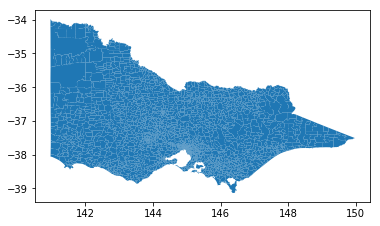

In [8]:
sdf1.plot()

Now performing the spatial join of the 2 geodataframes new_df,sdf1(The shape file data with the suburb geometry data)

In [9]:
df_suburb=gpd.sjoin(new_df,sdf1,how='left',op='within')
df=pd.DataFrame(df_suburb)#Converting the geodataframe to the pandas dataframe for further manipulations
df=df.drop(['index_right'],axis=1)
df.rename(columns={'VIC_LOCA_2':'suburb'},inplace=True)#renaming the columns
df.head()

,ID,Address,Rooms,Type,Price,Date,Bathroom,Car,Landsize,Age,Lattitude,Longtitude,geometry,suburb
0,ID256597507,18 Grimwade Ct,3,h,528000.0,27/05/2017,2.0,1.0,525.0,6.0,-37.65070,145.04681,POINT (145.0468100000001 -37.6507),EPPING
1,ID464726065,168 Scotchmer St,3,h,1581000.0,28/05/2016,1.0,0.0,193.0,109.0,-37.78360,144.98500,POINT (144.985 -37.7836),FITZROY NORTH
2,ID857676762,87 Palmerston St,3,h,1263000.0,9/09/2017,1.0,1.0,110.0,139.0,-37.79667,144.97204,POINT (144.97204 -37.79667),CARLTON
3,ID608833881,24 Mater St,2,h,1025000.0,3/06/2017,2.0,1.0,108.0,14.0,-37.79531,144.98630,POINT (144.9863 -37.79531),COLLINGWOOD
4,ID774776006,27 Vantage Bvd,4,h,800000.0,19/08/2017,2.0,2.0,511.0,6.0,-37.59372,144.89449,POINT (144.89449 -37.59372000000001),CRAIGIEBURN


Checking out the `df` dataframe we can see that we have got the suburb value after performing the spatial join with the given shape file.

### 4. Average crime columns(crime_A_average,crime_B_average,crime_C_average)
<a id=crime></a>

Now getting the council names of the suburbs using the council.txt, for extracting the council names which furhter helps to extract the crime average count from the crimes dataset.

In [10]:
text_file=open('council_dataset')
council_list=text_file.readlines()
text_file.close()    

Extracting the council name and the suburb name from the read list of the text file.

In [11]:
council_df = pd.DataFrame(columns=['council', 'suburb'])#Creating a empty dataframe
for value in council_list:
    new_dict={}#to store the data temporarily
    new_dict[value.split(':')[0].strip(' ')]=value.split(':')[1]#getting the council name
    all_suburbs=re.findall(re.compile(r"[\w]+[\s]?[\w]+"),new_dict[list(new_dict.keys())[0]])#Extracting all the suburb names
    new_dict[list(new_dict.keys())[0]]=all_suburbs#Adding the suburbs to the temporary dict
    council=list(new_dict.keys())[0]#getting the council name of the line
    for value in all_suburbs:
        #appending all the data by line to the council_df dataframe
        council_df=council_df.append({'council':council,'suburb':value},ignore_index=True)

In [12]:
council_df['suburb'] = council_df['suburb'].apply(lambda x: x.upper())
#converting all the suburb names to upper. As all the suburb data in the dataframe(df) is in uppercase.
council_df.head()

,council,suburb
0,BANYULE,ABBOTSFORD
1,BANYULE,AIRPORT WEST
2,BANYULE,ALBERT PARK
3,BANYULE,ALPHINGTON
4,BRIMBANK,ALTONA


In [13]:
df=pd.merge(df,council_df,how='left',left_on='suburb',right_on='suburb')
#adding the council data by joining the df(given dataframe) and the council_df.
#And also dropping the extra columns
df.head()

,ID,Address,Rooms,Type,Price,Date,Bathroom,Car,Landsize,Age,Lattitude,Longtitude,geometry,suburb,council
0,ID256597507,18 Grimwade Ct,3,h,528000.0,27/05/2017,2.0,1.0,525.0,6.0,-37.65070,145.04681,POINT (145.0468100000001 -37.6507),EPPING,FRANKSTON
1,ID464726065,168 Scotchmer St,3,h,1581000.0,28/05/2016,1.0,0.0,193.0,109.0,-37.78360,144.98500,POINT (144.985 -37.7836),FITZROY NORTH,WHITTLESEA
2,ID857676762,87 Palmerston St,3,h,1263000.0,9/09/2017,1.0,1.0,110.0,139.0,-37.79667,144.97204,POINT (144.97204 -37.79667),CARLTON,STRATHBOGIE
3,ID608833881,24 Mater St,2,h,1025000.0,3/06/2017,2.0,1.0,108.0,14.0,-37.79531,144.98630,POINT (144.9863 -37.79531),COLLINGWOOD,MOONEE VALLEY
4,ID774776006,27 Vantage Bvd,4,h,800000.0,19/08/2017,2.0,2.0,511.0,6.0,-37.59372,144.89449,POINT (144.89449 -37.59372000000001),CRAIGIEBURN,YARRA RANGES


<strong><b> Reading the crime dataset</b></strong>

In [14]:
xls = pd.ExcelFile('crimebylocationdatatable-yearending31march2016.xlsx')
crime_df=pd.read_excel(xls, 'Table 1')#Getting the Table 1 page
crime_df[0:20]

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,Table 1. Number of offences by geographic area...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Problems with the crime data<br>
1. From the above we can see that we don't need the rows from 0 to 17 <br>
2. Dropping the first column which has the NA values<br>
3. Row 18 has the column names.

In [15]:
#Dropping the first column i.e Unnamed: 0
crime_df=crime_df.drop('Unnamed: 0',axis=1)
crime_df=crime_df.drop(crime_df.index[[list(range(0,18))]]).reset_index().drop('index',axis=1)
#Dropping all the NA rows and reset index and deleting the old index column
crime_df.columns = crime_df.iloc[0]#Choosing the first row as the column names
crime_df=crime_df.drop(crime_df.index[[0]])#deleting the first row
crime_df=crime_df.reset_index().drop('index',axis=1)
crime_df.head()

C:\Users\Chandra\Anaconda3\lib\site-packages\pandas\core\indexes\base.py:3969: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)


,Apr - Mar reference period,Police Region,Police Service Area,Local Government Area,CSA Offence Division,CSA Offence Subdivision,Offence Count,LGA ERP,Victorian ERP
0,2012,1 North West Metro,BANYULE,BANYULE,A Crimes against the person,A10 Homicide and related offences,4,123600,5632521
1,2012,1 North West Metro,BANYULE,BANYULE,A Crimes against the person,A20 Assault and related offences,568,123600,5632521
2,2012,1 North West Metro,BANYULE,BANYULE,A Crimes against the person,A30 Sexual offences,132,123600,5632521
3,2012,1 North West Metro,BANYULE,BANYULE,A Crimes against the person,A40 Abduction and related offences,12,123600,5632521
4,2012,1 North West Metro,BANYULE,BANYULE,A Crimes against the person,A50 Robbery,46,123600,5632521


In [16]:
crime_df['Offence Count']=crime_df['Offence Count'].astype(np.int64)
#Converting the offence_count to int

Finding the sum of the number of offences based on the council name and the type of offence type.

In [17]:
aggregate_crimes=crime_df.groupby(['Local Government Area','CSA Offence Division','Apr - Mar reference period']).sum().reset_index()
aggregate_crimes.head()

,Local Government Area,CSA Offence Division,Apr - Mar reference period,Offence Count
0,ALPINE,A Crimes against the person,2012,72
1,ALPINE,A Crimes against the person,2013,78
2,ALPINE,A Crimes against the person,2014,85
3,ALPINE,A Crimes against the person,2015,99
4,ALPINE,A Crimes against the person,2016,93


Now getting the average crime_rate from `aggregate_crimes` dataframe for the different councils in the `df` dataframe.

In [18]:
aggregate_crimes['Apr - Mar reference period']=aggregate_crimes['Apr - Mar reference period'].astype(np.int64)
df['Date']=pd.to_datetime(df['Date'],format='%d/%m/%Y')
df['year']=df['Date'].dt.year

In [19]:
def get_crime(x,crime):
    year=x['year']
    council=x['council']
    years=list(range(year-3,year))
    total=0
    for i in years:
        value=aggregate_crimes['Offence Count'][np.logical_and(np.logical_and(aggregate_crimes['Local Government Area']==council,
                         aggregate_crimes['CSA Offence Division']==crime),
                                                           aggregate_crimes['Apr - Mar reference period']==i)]
        total=total+int(value)
    return total/3

In [20]:
df['crime_A_average']=df.apply(lambda x: get_crime(x,'A Crimes against the person'),axis=1)#getting the crime_A Data
df['crime_B_average']=df.apply(lambda x: get_crime(x,'B Property and deception offences'),axis=1)#getting the crime_B Data
df['crime_C_average']=df.apply(lambda x: get_crime(x,'C Drug offences'),axis=1)#getting the crime_C Data

In [21]:
df=df.drop(['geometry'],axis=1)
df.head()

,ID,Address,Rooms,Type,Price,Date,Bathroom,Car,Landsize,Age,Lattitude,Longtitude,suburb,council,year,crime_A_average,crime_B_average,crime_C_average
0,ID256597507,18 Grimwade Ct,3,h,528000.0,2017-05-27,2.0,1.0,525.0,6.0,-37.65070,145.04681,EPPING,FRANKSTON,2017,2006.666667,7754.333333,1051.333333
1,ID464726065,168 Scotchmer St,3,h,1581000.0,2016-05-28,1.0,0.0,193.0,109.0,-37.78360,144.98500,FITZROY NORTH,WHITTLESEA,2016,1923.666667,8979.333333,620.333333
2,ID857676762,87 Palmerston St,3,h,1263000.0,2017-09-09,1.0,1.0,110.0,139.0,-37.79667,144.97204,CARLTON,STRATHBOGIE,2017,101.333333,253.666667,33.000000
3,ID608833881,24 Mater St,2,h,1025000.0,2017-06-03,2.0,1.0,108.0,14.0,-37.79531,144.98630,COLLINGWOOD,MOONEE VALLEY,2017,1097.666667,5916.000000,553.333333
4,ID774776006,27 Vantage Bvd,4,h,800000.0,2017-08-19,2.0,2.0,511.0,6.0,-37.59372,144.89449,CRAIGIEBURN,YARRA RANGES,2017,1288.333333,4242.333333,480.000000


From the above dataframe we can see that we have go the different crime data to the given dataframe.

### 5.Reading the GTFS data.
<a id=gtfs></a>

 The 2 folders has the data of the victoria and the data related to the metro trains, Hence only reading the data from the folder 1 and 2 and concatinating them.<br>
Note: The files are unzipped externally and loaded into the jupyter server, please make sure of the directory path for loading the gtfs data.

Now reading the stops data.

In [22]:
stops1=pd.read_csv('1/stops.txt',sep=',',header='infer')
stops2=pd.read_csv('2/stops.txt',sep=',',header='infer')
stops=pd.concat([stops1,stops2],axis=0)
stops=stops.reset_index()
stops=stops.drop(['index'],axis=1)
stops.head()

,stop_id,stop_name,stop_lat,stop_lon
0,17204,Wallan Railway Station (Wallan),-37.416861,145.005372
1,19980,Melton Railway Station (Melton South),-37.703293,144.572524
2,19981,Rockbank Railway Station (Rockbank),-37.729261,144.650631
3,19982,Deer Park Railway Station (Deer Park),-37.777764,144.772304
4,19998,Sunbury Railway Station (Sunbury),-37.579206,144.728165


Reading the stop_times data.

In [23]:
stop_times1=pd.read_csv('1/stop_times.txt',sep=',',header='infer')
stop_times2=pd.read_csv('2/stop_times.txt',sep=',',header='infer')
stop_times=pd.concat([stop_times1,stop_times2],axis=0)
stop_times=stop_times.reset_index()
stop_times=stop_times.drop(['index'],axis=1)
stop_times.head()

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,stop_headsign,pickup_type,drop_off_type,shape_dist_traveled
0,7548.UR.1-V08-A-mjp-1.1.H,06:08:00,06:08:00,20291,1,NaN,0,0,0.000000
1,7548.UR.1-V08-A-mjp-1.1.H,06:42:00,06:42:00,20346,2,NaN,0,0,52720.840026
2,7548.UR.1-V08-A-mjp-1.1.H,06:55:00,06:57:00,20341,3,NaN,0,0,68786.649688
3,7548.UR.1-V08-A-mjp-1.1.H,07:16:00,07:16:00,20339,4,NaN,0,0,94514.728171
4,7548.UR.1-V08-A-mjp-1.1.H,07:32:00,07:34:00,20351,5,NaN,0,0,116895.210301


Changing the datatypes of the arrival_time and the departure_time which is actually a object type.
<br>
The hours_correct function corrects the format 26:26:45 to 2:26:45.
<br>
The convert function used to convert the string to the datetime format.

In [24]:
def hours_correct(x):
    val=x
    hours=val[0:2]
    return (pd.to_datetime(str(int(hours)-24)+val[2:],format='%H:%M:%S',errors='raise'))

In [25]:
def convert(x,name):
    value=x[name]
    try:
        return_val=pd.to_datetime(value,format='%H:%M:%S',errors='raise')
        return(return_val)
    except:
        return_val=hours_correct(value)
        return(return_val)

In [26]:
stop_times['departure_time']=stop_times.apply(lambda x: convert(x,'departure_time'),axis=1)
stop_times['arrival_time']=stop_times.apply(lambda x : convert(x,'arrival_time'),axis=1)
#Applying the function

In [27]:
#extracting only the time from the timestamp.
stop_times['departure_time']=stop_times['departure_time'].dt.time
stop_times['arrival_time']=stop_times['arrival_time'].dt.time

In [28]:
stop_times.head()

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,stop_headsign,pickup_type,drop_off_type,shape_dist_traveled
0,7548.UR.1-V08-A-mjp-1.1.H,06:08:00,06:08:00,20291,1,NaN,0,0,0.000000
1,7548.UR.1-V08-A-mjp-1.1.H,06:42:00,06:42:00,20346,2,NaN,0,0,52720.840026
2,7548.UR.1-V08-A-mjp-1.1.H,06:55:00,06:57:00,20341,3,NaN,0,0,68786.649688
3,7548.UR.1-V08-A-mjp-1.1.H,07:16:00,07:16:00,20339,4,NaN,0,0,94514.728171
4,7548.UR.1-V08-A-mjp-1.1.H,07:32:00,07:34:00,20351,5,NaN,0,0,116895.210301


Now reading the trips data from the given gtfs folder.

In [29]:
trips1=pd.read_csv('1/trips.txt',sep=',',header='infer')
trips2=pd.read_csv('2/trips.txt',sep=',',header='infer')
trips=pd.concat([trips1,trips2],axis=0)
trips=trips.reset_index()
trips=trips.drop(['index'],axis=1)
trips.head()

,route_id,service_id,trip_id,shape_id,trip_headsign,direction_id
0,1-V08-G-mjp-1,T0,1051.T0.1-V08-G-mjp-1.1.H,1-V08-G-mjp-1.1.H,Melbourne,0
1,1-V08-G-mjp-1,T0,1052.T0.1-V08-G-mjp-1.2.H,1-V08-G-mjp-1.2.H,Melbourne,0
2,1-V08-G-mjp-1,T0,1053.T0.1-V08-G-mjp-1.2.H,1-V08-G-mjp-1.2.H,Melbourne,0
3,1-V08-G-mjp-1,T0,1522.T0.1-V08-G-mjp-1.4.R,1-V08-G-mjp-1.4.R,Bairnsdale,1
4,1-V08-G-mjp-1,T0,1523.T0.1-V08-G-mjp-1.5.R,1-V08-G-mjp-1.5.R,Bairnsdale,1


Getting the stopid's of the southern cross station

In [30]:
stops[stops['stop_name']=='Southern Cross Railway Station (Melbourne City)']

,stop_id,stop_name,stop_lat,stop_lon
7,20043,Southern Cross Railway Station (Melbourne City),-37.818334,144.952525
319,22180,Southern Cross Railway Station (Melbourne City),-37.817936,144.951411


Now getting all the trip_id's associated with southern crross station(20043 and 22180)

In [31]:
sc_trips_list=stop_times['trip_id'][(stop_times['stop_id']==20043)|(stop_times['stop_id']==22180)]

In [32]:
#now getting all the data of these trips in the sc_list
sc_df=stop_times[stop_times['trip_id'].isin(sc_trips_list)]
sc_df.head()#has all the trips which are associated with southern cross.

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,stop_headsign,pickup_type,drop_off_type,shape_dist_traveled
0,7548.UR.1-V08-A-mjp-1.1.H,06:08:00,06:08:00,20291,1,NaN,0,0,0.000000
1,7548.UR.1-V08-A-mjp-1.1.H,06:42:00,06:42:00,20346,2,NaN,0,0,52720.840026
2,7548.UR.1-V08-A-mjp-1.1.H,06:55:00,06:57:00,20341,3,NaN,0,0,68786.649688
3,7548.UR.1-V08-A-mjp-1.1.H,07:16:00,07:16:00,20339,4,NaN,0,0,94514.728171
4,7548.UR.1-V08-A-mjp-1.1.H,07:32:00,07:34:00,20351,5,NaN,0,0,116895.210301


Now getting the service_id from trips data for the trip's in `sc_df`.

In [33]:
#performing the join of sc_df and trips
sc_df=pd.merge(sc_df,trips[['service_id','trip_id','direction_id']],how='left',on='trip_id')

Now reading the calenders data which furhter helps to determine of the trip if available in all the weekdays.

In [34]:
calenders1=pd.read_csv('1/calendar.txt',sep=',',header='infer')
calenders2=pd.read_csv('2/calendar.txt',sep=',',header='infer')
calenders=pd.concat([calenders1,calenders2],axis=0)
calenders=calenders.reset_index()
calenders=calenders.drop(['index'],axis=1)
calenders.head()

,service_id,monday,tuesday,wednesday,thursday,friday,saturday,sunday,start_date,end_date
0,UR,0,0,0,1,0,0,0,20190509,20190509
1,T6,0,0,0,0,1,0,0,20190510,20190510
2,T2,0,0,0,0,0,1,0,20190511,20190511
3,UJ,0,0,0,0,0,0,1,20190512,20190512
4,UO,1,0,0,0,0,0,0,20190513,20190513


Now getting all the service id from the calenders data where all the weekdays is 1

In [35]:
week_services=list(calenders['service_id'][(calenders['monday']==1)&(calenders['tuesday']==1)&(calenders['wednesday']==1)&
                        (calenders['thursday']==1)&(calenders['friday']==1)])

Now keeping all the tripid's which are on all the weekdays.

In [36]:
sc_week_df=sc_df[sc_df['service_id'].isin(week_services)]
sc_week_df.head()

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,stop_headsign,pickup_type,drop_off_type,shape_dist_traveled,service_id,direction_id
578,1051.T0.1-V08-G-mjp-1.1.H,06:08:00,06:08:00,20291,1,NaN,0,0,0.000000,T0,0
579,1051.T0.1-V08-G-mjp-1.1.H,06:42:00,06:42:00,20346,2,NaN,0,0,52720.840026,T0,0
580,1051.T0.1-V08-G-mjp-1.1.H,06:55:00,06:57:00,20341,3,NaN,0,0,68786.649688,T0,0
581,1051.T0.1-V08-G-mjp-1.1.H,07:16:00,07:16:00,20339,4,NaN,0,0,94514.728171,T0,0
582,1051.T0.1-V08-G-mjp-1.1.H,07:32:00,07:34:00,20351,5,NaN,0,0,116895.210301,T0,0


`sc_week_df` has only the trips which are associated with southern cross station and the trips which run on all week days.

### 6. train_station_id & distance_to_train_station
<a id=station></a>

The hav function calculates the haversine distance between the 2 geo points.

In [37]:
#Function to calculate the haversine distance between 2 geo points.
def hav(l1,l2,lo1,lo2):#Using the haverns distance to calculate the distance between2 geospatial points
    R=6378000
    lat1=radians(l1)
    lat2=radians(l2)
    lon1=radians(lo1)
    lon2=radians(lo2)
    diff_lat=lat2-lat1
    diff_lon=lon2-lon1
    a=sin(diff_lat/2)**2+cos(lat1)*cos(lat2)*sin(diff_lon/2)**2
    c=2*atan2((a)**0.5,(1-a)**0.5)
    d=R*c
    return d

The nearest_station function takes in each row as the input, and then the follows the process as<br>
1. Calcualtes the distances to all the stops in stops data and stores in `return_df` and then sorted based on the nearest deistance.<br>
2. Considering the return_df calculated in the first step, and checking from the nearest station which has a trip to southern cross station between 7am and 9:30am and also checking atleast if a single trip has destination as southern cross.
4. On satisfying the above conditions the function returns the particular stop_id and the distance to that respective station.

In [38]:
#The nearest_station calculates the neares station to the peoperty.
def nearest_station(d):
    #print(d['Lattitude'])
    l1=d['Lattitude']
    lo1=d['Longtitude']
    nearest_distances=stops.apply(lambda x: (hav(l1,x['stop_lat'],lo1,x['stop_lon']),x['stop_id']),axis=1)
    #The above line finds the distances to all the stations from a particular station in our given data.
    return_df=pd.DataFrame(list(nearest_distances),columns=['distance','stop_id']).sort_values(by='distance')
    #Now storing the diatances and the staion_id to the newdataframe and sorting based on the distance.
    return_df=return_df.reset_index()
    return_df=return_df.drop(['index'],axis=1)
    for index,value in return_df.iterrows():
        #taking the nearest station and checking if the station has a trip to southern cross between 7and 9:30am.
        #And also checking that southern cross as destination by veryfing that arrival > departure time.
        if return_df['stop_id'][index] in ([22180,20043]):
            return (return_df['stop_id'][index],return_df['distance'][index])
        else:
            get_all_trips=sc_week_df['trip_id'][(sc_week_df['stop_id']==return_df['stop_id'][index])]
            for tr in list(get_all_trips):
                temp_dep=sc_week_df['departure_time'][(sc_week_df['trip_id']==tr)&(sc_week_df['stop_id']==return_df['stop_id'][index])]
                temp_arr=sc_week_df['arrival_time'][(sc_week_df['trip_id']==tr)&
                                                    (sc_week_df['stop_id'].isin([22180,20043]))]
                if (list(temp_dep)[0]>=dt.time(7,0,0))&(list(temp_dep)[0]<=dt.time(9,30,0)):
                    if list(temp_dep)[0]<list(temp_arr)[0]:
                        return (return_df['stop_id'][index],return_df['distance'][index])
                    else:
                        continue
                else:
                    continue
    return (return_df['stop_id'][0],return_df['distance'][0])
#returning the nearest station and the distance if the return in above functions are not executed.

For parallel processing we are using the Dask package which process the data parallelly.<br>Hence converitng the `df` to dask dataframe and mentioning partitions as 4 as our cpu is 4 cores.

In [39]:
scd=dd.from_pandas(df,npartitions=4)
#converting the given data to the dask data for implementing parallel computaion.
scd=scd.persist()#making the dask frame in memory

Applying the nearest_station function to all the partitions of the dask dataframe and storing them in the other column where we can further extract the data from.

In [40]:
df['check_column']=scd.map_partitions(lambda df2: df2.apply(lambda x: nearest_station(x), axis=1)).compute(scheduler='processes')
#applying the nearest_station function to all the partitions, here we are applying the function parallerlly to all the partitions.
df.head()

,ID,Address,Rooms,Type,Price,Date,Bathroom,Car,Landsize,Age,Lattitude,Longtitude,suburb,council,year,crime_A_average,crime_B_average,crime_C_average,check_column
0,ID256597507,18 Grimwade Ct,3,h,528000.0,2017-05-27,2.0,1.0,525.0,6.0,-37.65070,145.04681,EPPING,FRANKSTON,2017,2006.666667,7754.333333,1051.333333,"(20005, 1482.7544290359062)"
1,ID464726065,168 Scotchmer St,3,h,1581000.0,2016-05-28,1.0,0.0,193.0,109.0,-37.78360,144.98500,FITZROY NORTH,WHITTLESEA,2016,1923.666667,8979.333333,620.333333,"(20019, 653.0488940807458)"
2,ID857676762,87 Palmerston St,3,h,1263000.0,2017-09-09,1.0,1.0,110.0,139.0,-37.79667,144.97204,CARLTON,STRATHBOGIE,2017,101.333333,253.666667,33.000000,"(19843, 1603.022537633251)"
3,ID608833881,24 Mater St,2,h,1025000.0,2017-06-03,2.0,1.0,108.0,14.0,-37.79531,144.98630,COLLINGWOOD,MOONEE VALLEY,2017,1097.666667,5916.000000,553.333333,"(19975, 835.2041503586546)"
4,ID774776006,27 Vantage Bvd,4,h,800000.0,2017-08-19,2.0,2.0,511.0,6.0,-37.59372,144.89449,CRAIGIEBURN,YARRA RANGES,2017,1288.333333,4242.333333,480.000000,"(40221, 4400.042209133973)"


In [41]:
df['train_station_id']=df.apply(lambda x: x['check_column'][0],axis=1)#getting all the station_id from the tuple
df['distance_to_train_station']=df.apply(lambda x: x['check_column'][1],axis=1)
#getting the distance to train station from the tuple
df=df.drop(['check_column'],axis=1)
#dropping the extra column where we have stored the returned tuple from the function nearest_station.
df.head()

,ID,Address,Rooms,Type,Price,Date,Bathroom,Car,Landsize,Age,Lattitude,Longtitude,suburb,council,year,crime_A_average,crime_B_average,crime_C_average,train_station_id,distance_to_train_station
0,ID256597507,18 Grimwade Ct,3,h,528000.0,2017-05-27,2.0,1.0,525.0,6.0,-37.65070,145.04681,EPPING,FRANKSTON,2017,2006.666667,7754.333333,1051.333333,20005,1482.754429
1,ID464726065,168 Scotchmer St,3,h,1581000.0,2016-05-28,1.0,0.0,193.0,109.0,-37.78360,144.98500,FITZROY NORTH,WHITTLESEA,2016,1923.666667,8979.333333,620.333333,20019,653.048894
2,ID857676762,87 Palmerston St,3,h,1263000.0,2017-09-09,1.0,1.0,110.0,139.0,-37.79667,144.97204,CARLTON,STRATHBOGIE,2017,101.333333,253.666667,33.000000,19843,1603.022538
3,ID608833881,24 Mater St,2,h,1025000.0,2017-06-03,2.0,1.0,108.0,14.0,-37.79531,144.98630,COLLINGWOOD,MOONEE VALLEY,2017,1097.666667,5916.000000,553.333333,19975,835.204150
4,ID774776006,27 Vantage Bvd,4,h,800000.0,2017-08-19,2.0,2.0,511.0,6.0,-37.59372,144.89449,CRAIGIEBURN,YARRA RANGES,2017,1288.333333,4242.333333,480.000000,40221,4400.042209


### 7. travel_min_to_CBD
<a id=time></a>

`sc_trips_df` data has all the trips associated with southern cross, but it has both the trips which has southern cross as destination and origin as southern cross. Hence while calcualting the travel time we are checking that the stop we are considering is prior to the southercross and considering only these trips to calculate the travel time to CBD.

Now cleaning up the `sc_trips_df` so that we have only the rows with the departure time window between 7am and 9:30am.

In [42]:
def travel(j,stop):
    #print(j['trip_id'])
    temp_departure=sc_week_df['departure_time'][(sc_week_df['trip_id']==j['trip_id'])&(sc_week_df['stop_id']==stop)]
    temp_arrival=sc_week_df['arrival_time'][(sc_week_df['trip_id']==j['trip_id']) & ((sc_week_df['stop_id']==20043)|
                                                                     (sc_week_df['stop_id']==22180))]
    #print(temp_departure)
    #print('------',temp_arrival)
    if (list(temp_departure)[0]>=dt.time(7,0,0))&(list(temp_departure)[0]<=dt.time(9,30,0)):
        if (list(temp_departure)[0]<list(temp_arrival)[0]):
            delta=datetime.combine(date.min,list(temp_arrival)[0]) - datetime.combine(date.min, list(temp_departure)[0])
            return (int(str(delta.seconds))/60)
        else:
            return np.nan
    else:
        return np.nan

The travel_time function takes a row object of a dataframe as the input and follows the following process in calculating the average travel_time_CBD form each nearest station to southerncross.
1. Fetch all the trip_id's associated with the passed on station_id from the `sc_week_df`.
2. For each trip_id check the conditions like if the departure_time is between 7am and 9:30am, and also then verifying if the departure time if less thn the arrival time, which makes a valid trip to calculate the time travelled by fincding the difference betweent the dfference between departure and the arrival time.(where the implementiation is done in the travel function.)
3. Then the times are stored in temp_df w.r.t trip_id and then null values are dropped in the dataframe.
4. The mean of the column 'time' in the `temp_df` is returned.

In [43]:
def travel_time(x):
    stop=int(x['train_station_id'])
    #print('-------------',stop)
    #now getting all the list of trips which for the station_id from the sc_trips_weekdays data
    temp_df=pd.DataFrame(columns=['trip_id'])
    temp_df['trip_id']=sc_week_df['trip_id'][sc_week_df['stop_id']==stop].unique()
    value=temp_df.apply(lambda g :travel(g,stop),axis=1)
    if len(value)==0:
        return 0
    temp_df['time']=value
    #temp_df['time']=temp_df.apply(lambda g :travel(g,stop),axis=1)
    print(temp_df)
    temp_df=temp_df.dropna(axis=0, subset=['time'])
    #temp_df=temp_df[temp_df['time']<600]
    print(temp_df)
    return temp_df['time'].mean()
    

Considering only the unique stopid's to find the travel_time_cbd so that we can reduce the number of computation.

In [44]:
less=df.drop_duplicates(subset='train_station_id')

In [45]:
sdc=dd.from_pandas(less,npartitions=4)
#Converting to dask datafrmae for parallel computation.
sdc=sdc.persist()

Applying the travel_time function to the above dask function and storing it in the `less` dataframe which results in a data frame with stop_id and their respective travel_time to CBD.

In [46]:
less['travel_min_to_CBD']=sdc.map_partitions(lambda df: df.apply(lambda x: travel_time(x), axis=1)).compute(scheduler='processes')
less.head()

C:\Users\Chandra\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,ID,Address,Rooms,Type,Price,Date,Bathroom,Car,Landsize,Age,...,Longtitude,suburb,council,year,crime_A_average,crime_B_average,crime_C_average,train_station_id,distance_to_train_station,travel_min_to_CBD
0,ID256597507,18 Grimwade Ct,3,h,528000.0,2017-05-27,2.0,1.0,525.0,6.0,...,145.04681,EPPING,FRANKSTON,2017,2006.666667,7754.333333,1051.333333,20005,1482.754429,45.222222
1,ID464726065,168 Scotchmer St,3,h,1581000.0,2016-05-28,1.0,0.0,193.0,109.0,...,144.98500,FITZROY NORTH,WHITTLESEA,2016,1923.666667,8979.333333,620.333333,20019,653.048894,18.300000
2,ID857676762,87 Palmerston St,3,h,1263000.0,2017-09-09,1.0,1.0,110.0,139.0,...,144.97204,CARLTON,STRATHBOGIE,2017,101.333333,253.666667,33.000000,19843,1603.022538,6.100559
3,ID608833881,24 Mater St,2,h,1025000.0,2017-06-03,2.0,1.0,108.0,14.0,...,144.98630,COLLINGWOOD,MOONEE VALLEY,2017,1097.666667,5916.000000,553.333333,19975,835.204150,13.235294
4,ID774776006,27 Vantage Bvd,4,h,800000.0,2017-08-19,2.0,2.0,511.0,6.0,...,144.89449,CRAIGIEBURN,YARRA RANGES,2017,1288.333333,4242.333333,480.000000,40221,4400.042209,49.000000


As the travel_time returns NA values if the passed on station to the function is southerncross station as there are no trips from southerncross station to the same as destination. Hence changing those rows to default values i.e 0

In [47]:
less['travel_min_to_CBD'][less['travel_min_to_CBD'].isna()]=0
less.head()

C:\Users\Chandra\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\Chandra\Anaconda3\lib\site-packages\pandas\core\generic.py:8682: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
C:\Users\Chandra\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  exec(code_obj, self.user_global_ns, self.user

,ID,Address,Rooms,Type,Price,Date,Bathroom,Car,Landsize,Age,...,Longtitude,suburb,council,year,crime_A_average,crime_B_average,crime_C_average,train_station_id,distance_to_train_station,travel_min_to_CBD
0,ID256597507,18 Grimwade Ct,3,h,528000.0,2017-05-27,2.0,1.0,525.0,6.0,...,145.04681,EPPING,FRANKSTON,2017,2006.666667,7754.333333,1051.333333,20005,1482.754429,45.222222
1,ID464726065,168 Scotchmer St,3,h,1581000.0,2016-05-28,1.0,0.0,193.0,109.0,...,144.98500,FITZROY NORTH,WHITTLESEA,2016,1923.666667,8979.333333,620.333333,20019,653.048894,18.300000
2,ID857676762,87 Palmerston St,3,h,1263000.0,2017-09-09,1.0,1.0,110.0,139.0,...,144.97204,CARLTON,STRATHBOGIE,2017,101.333333,253.666667,33.000000,19843,1603.022538,6.100559
3,ID608833881,24 Mater St,2,h,1025000.0,2017-06-03,2.0,1.0,108.0,14.0,...,144.98630,COLLINGWOOD,MOONEE VALLEY,2017,1097.666667,5916.000000,553.333333,19975,835.204150,13.235294
4,ID774776006,27 Vantage Bvd,4,h,800000.0,2017-08-19,2.0,2.0,511.0,6.0,...,144.89449,CRAIGIEBURN,YARRA RANGES,2017,1288.333333,4242.333333,480.000000,40221,4400.042209,49.000000


Joining the `less` dataframe and the given datframe `df` to get the average travel_times to the southern cross station.

In [48]:
df=pd.merge(df,less[['train_station_id','travel_min_to_CBD']],how='left',on='train_station_id')
df.head()

,ID,Address,Rooms,Type,Price,Date,Bathroom,Car,Landsize,Age,...,Longtitude,suburb,council,year,crime_A_average,crime_B_average,crime_C_average,train_station_id,distance_to_train_station,travel_min_to_CBD
0,ID256597507,18 Grimwade Ct,3,h,528000.0,2017-05-27,2.0,1.0,525.0,6.0,...,145.04681,EPPING,FRANKSTON,2017,2006.666667,7754.333333,1051.333333,20005,1482.754429,45.222222
1,ID464726065,168 Scotchmer St,3,h,1581000.0,2016-05-28,1.0,0.0,193.0,109.0,...,144.98500,FITZROY NORTH,WHITTLESEA,2016,1923.666667,8979.333333,620.333333,20019,653.048894,18.300000
2,ID857676762,87 Palmerston St,3,h,1263000.0,2017-09-09,1.0,1.0,110.0,139.0,...,144.97204,CARLTON,STRATHBOGIE,2017,101.333333,253.666667,33.000000,19843,1603.022538,6.100559
3,ID608833881,24 Mater St,2,h,1025000.0,2017-06-03,2.0,1.0,108.0,14.0,...,144.98630,COLLINGWOOD,MOONEE VALLEY,2017,1097.666667,5916.000000,553.333333,19975,835.204150,13.235294
4,ID774776006,27 Vantage Bvd,4,h,800000.0,2017-08-19,2.0,2.0,511.0,6.0,...,144.89449,CRAIGIEBURN,YARRA RANGES,2017,1288.333333,4242.333333,480.000000,40221,4400.042209,49.000000


### 8. over priced
<a id=price></a>

A property is over_priced or not is verified in the following process:<br>
1. First groupby based on the features ['Rooms','Typr','Bathroom','Car','suburb','year'] and finding the median based on the features.<br>
2. Now performing the join based on the features discussed above and creating a other column which consists of median price for particular features.<br>
3. Checking if the given price is greater than the predicted price, if so '1' is the value indicating that it is overpriced or else '0' is placed in the 'over_prices?' column.

In [50]:
price_agg=df.groupby(['Rooms','Type','Bathroom','Car','suburb','year']).agg({'Price':'median'}).reset_index()
#Finding the median based on the features given to consider in the specifications.

In [51]:
df=pd.merge(df,price_agg,how='left',on=['Rooms','Type','Bathroom','Car','suburb','year'])
#Joining the df dataframe to the and the price_agg to get the median price of different values of the features.
df.rename(columns={'Price_y': 'pred_price', 'Price_x': 'Price'}, inplace=True)
#For esy understanding the columns are renamed.
df.head()

,ID,Address,Rooms,Type,Price,Date,Bathroom,Car,Landsize,Age,...,suburb,council,year,crime_A_average,crime_B_average,crime_C_average,train_station_id,distance_to_train_station,travel_min_to_CBD,pred_price
0,ID256597507,18 Grimwade Ct,3,h,528000.0,2017-05-27,2.0,1.0,525.0,6.0,...,EPPING,FRANKSTON,2017,2006.666667,7754.333333,1051.333333,20005,1482.754429,45.222222,544000.0
1,ID464726065,168 Scotchmer St,3,h,1581000.0,2016-05-28,1.0,0.0,193.0,109.0,...,FITZROY NORTH,WHITTLESEA,2016,1923.666667,8979.333333,620.333333,20019,653.048894,18.300000,1581000.0
2,ID857676762,87 Palmerston St,3,h,1263000.0,2017-09-09,1.0,1.0,110.0,139.0,...,CARLTON,STRATHBOGIE,2017,101.333333,253.666667,33.000000,19843,1603.022538,6.100559,1263000.0
3,ID608833881,24 Mater St,2,h,1025000.0,2017-06-03,2.0,1.0,108.0,14.0,...,COLLINGWOOD,MOONEE VALLEY,2017,1097.666667,5916.000000,553.333333,19975,835.204150,13.235294,1025000.0
4,ID774776006,27 Vantage Bvd,4,h,800000.0,2017-08-19,2.0,2.0,511.0,6.0,...,CRAIGIEBURN,YARRA RANGES,2017,1288.333333,4242.333333,480.000000,40221,4400.042209,49.000000,600000.0


In [52]:
df['over_priced?']=df.apply(lambda x: 1 if x['Price']>x['pred_price'] else 0,axis=1)
#If the predicted value is greater than the actual price then considered as over_priced.
df=df.drop(['pred_price','council'],axis=1)

In [53]:
df.columns

Index(['ID', 'Address', 'Rooms', 'Type', 'Price', 'Date', 'Bathroom', 'Car',
       'Landsize', 'Age', 'Lattitude', 'Longtitude', 'suburb', 'year',
       'crime_A_average', 'crime_B_average', 'crime_C_average',
       'train_station_id', 'distance_to_train_station', 'travel_min_to_CBD',
       'over_priced?'],
      dtype='object')

In [54]:
out_df=df[['ID','Address','suburb','Price','Type','Date','Rooms','Bathroom','Car','Landsize','Age','Lattitude','Longtitude',
   'train_station_id','distance_to_train_station','travel_min_to_CBD','over_priced?','crime_A_average','crime_B_average',
   'crime_C_average']]

In [55]:
df_col=['ID','Address','Suburb','Price','Type','Date','Rooms','Bathroom','Car','LandSize','Age','Latitude','Longitude',
   'train_station_id','distance_to_train_station','travel_min_to_CBD','over_priced?','crime_A_average','crime_B_average',
   'crime_C_average']
out_df.columns=df_col

#### Integrated data

In [56]:
out_df.head()

,ID,Address,Suburb,Price,Type,Date,Rooms,Bathroom,Car,LandSize,Age,Latitude,Longitude,train_station_id,distance_to_train_station,travel_min_to_CBD,over_priced?,crime_A_average,crime_B_average,crime_C_average
0,ID256597507,18 Grimwade Ct,EPPING,528000.0,h,2017-05-27,3,2.0,1.0,525.0,6.0,-37.65070,145.04681,20005,1482.754429,45.222222,0,2006.666667,7754.333333,1051.333333
1,ID464726065,168 Scotchmer St,FITZROY NORTH,1581000.0,h,2016-05-28,3,1.0,0.0,193.0,109.0,-37.78360,144.98500,20019,653.048894,18.300000,0,1923.666667,8979.333333,620.333333
2,ID857676762,87 Palmerston St,CARLTON,1263000.0,h,2017-09-09,3,1.0,1.0,110.0,139.0,-37.79667,144.97204,19843,1603.022538,6.100559,0,101.333333,253.666667,33.000000
3,ID608833881,24 Mater St,COLLINGWOOD,1025000.0,h,2017-06-03,2,2.0,1.0,108.0,14.0,-37.79531,144.98630,19975,835.204150,13.235294,0,1097.666667,5916.000000,553.333333
4,ID774776006,27 Vantage Bvd,CRAIGIEBURN,800000.0,h,2017-08-19,4,2.0,2.0,511.0,6.0,-37.59372,144.89449,40221,4400.042209,49.000000,1,1288.333333,4242.333333,480.000000


### 10. Conclusion
<a id=conclusion></a>

From this work  we are able to learn how useful the data can be when you integrate the data, and also able devise the importance of reshaping for a better predective model.<br>
<B>Reading the shape files:</B> we have learnt how to deal with the shape files and also the geodata with the use of `geopandas` library.<br>
<B>Data Integration:</B> We are able to get the usefulness of the data when integrating with the other available data.<br>
<B> GTFS:</B> We are able to refer to the public transport API and also how to understand and integrate the data witht the GTFS data.

### 11. References.
<a id=references></a>

1. The pandas documentation of using the dataframes adn groupby:https://pandas.pydata.org/pandas-docs/stable/<br>
2. The geopandas documentation which is used to perform the spatial join and reading the shape files for performing the geobased calcualtions: http://geopandas.org/<br>
3. The Dask for implmenting the faster processing of the numpy and pandas dataframe. http://docs.dask.org/en/latest/api.html<br>
4. The numpy package for performing the mathematical operations https://docs.scipy.org/doc/<br>
5. The matplotlib for plotting the graphs can referrred using the https://matplotlib.org/3.1.0/contents.html
6. The seaborn package for plotting tthe graphs can be reffered from https://seaborn.pydata.org/
7. A little reference on the spatial join of the geo data. https://github.com/bobhaffner/medium_posts/blob/master/geopandas_sjoin/geopandas_sjoin.ipynb